# Plain-Text CNN

## Preparations

### options

In [1]:
%reload_ext autoreload
%autoreload 2
dir_data = '../data/power_consumption/'

### modules

In [2]:
import pandas as pd  # data mangling and transforming
import numpy as np  # handling vectors and matrices
import matplotlib.pyplot as plt  # plotting
from sklearn.metrics import mean_squared_error  # MSE error metric
from analysis_functions import evaluate_forecasts  # own functions

# pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam, Adagrad, SGD

Using TensorFlow backend.


### dataset

In [3]:
train_X = np.load(dir_data+'train_Xu.npy')
train_y = np.load(dir_data+'train_yu.npy')

In [4]:
print(train_X.shape)
print(train_y.shape)

(995, 7, 1)
(995, 7)


994 Observations for 7 days for 1 Variable!

In [5]:
test_X = np.load(dir_data+'test_Xs.npy')[:,:,:1]
test_y = np.load(dir_data+'test_ys.npy')

In [6]:
print(test_X.shape)
print(test_y.shape)

(60, 7, 1)
(60, 7)


## Modeling

### Options

In [7]:
# net hyper parameters
epochs = 20
batch_size = 4
lr = 0.001
n_filters = 16
n_linear = 10

In [8]:
# dimensions
n_timesteps = train_X.shape[1] 
n_features = train_X.shape[2]
n_outputs = train_y.shape[1] 

### Tensorflow

In [9]:
def train_tf_model(train_X, train_y,
                   batch_size, epochs, lr,
                   n_timesteps, n_features, n_outputs):
    
    # build model
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', 
                     input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(n_linear, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer=Adam(lr=lr))
    
    # fit the model
    model.fit(train_X, train_y, 
              epochs=epochs, batch_size=batch_size,
              verbose=0)
    
    # return model
    return model

In [10]:
def pred_tf_model(test_X, test_y, model):
    # create predictions
    preds = model.predict(test_X)
    
    # print RMSE
    rmse = evaluate_forecasts(test_y, preds)
    print('Overall RMSE for TF model: %s!'%rmse[0])
    
    # return predictions and RMSE
    return preds, rmse

### Pytorch

In [11]:
# define class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(n_features, n_filters, 3, stride=1)
        self.aps = int(np.floor((n_timesteps-3+1)/2))
        self.l1 = nn.Linear(n_filters*self.aps, n_linear)
        self.l2 = nn.Linear(n_linear, n_outputs)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=2)
        x = x.view(-1, n_filters*self.aps) # flatten
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [12]:
def train_pt_model(train_X, train_y,
                   batch_size, epochs, lr,
                   n_timesteps, n_features, n_outputs):
    
    # transform data to tensors (reshape dimensions of X)
    train_X = torch.from_numpy(np.array(train_X.reshape(train_X.shape[0], 
                                                        train_X.shape[2], 
                                                        train_X.shape[1]), dtype='float32'))
    train_y = torch.from_numpy(np.array(train_y, dtype='float32'))
    
    
    # create dataloader
    train_Xy = DataLoader(TensorDataset(train_X, train_y), 
                          batch_size, 
                          shuffle=True)
    
    # build model
    model = Net()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = F.mse_loss
    
    # fit the model
    def fit(df, num_epochs, model, loss_fn, opt):
        for epoch in range(num_epochs):
            for xb,yb in df:
                # Generate predictions
                pred = model(xb)
                loss = loss_fn(pred, yb)
                # Perform gradient descent
                opt.zero_grad()
                loss.backward()
                opt.step()
            
    fit(train_Xy, epochs, model, loss_fn, opt)
    
    # return model
    return model

In [13]:
def pred_pt_model(test_X, test_y, model):
    
    # transform data to tensors (reshape dimensions of X)
    test_X = torch.from_numpy(np.array(test_X.reshape(test_X.shape[0], 
                                                      test_X.shape[2], 
                                                      test_X.shape[1]), dtype='float32'))
    
    # create predictions
    preds = model(test_X).data.numpy()

    # print RMSE
    rmse = evaluate_forecasts(test_y, preds)
    print('Overall RMSE for PT model: %s!'%rmse[0])
    
    # return predictions and RMSE
    return preds, rmse
    

#### Comparison

**Predictions & RMSE**

In [14]:
# tensorflow
model_tf = train_tf_model(train_X, train_y, 
                          batch_size, epochs, lr,
                          n_timesteps, n_features, n_outputs)
y_tf, rmse_tf = pred_tf_model(test_X, test_y, model_tf)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Overall RMSE for TF model: 405.80943408101626!


In [15]:
# pytorch
model_pt = train_pt_model(train_X, train_y,
                          batch_size, epochs, lr,
                          n_timesteps, n_features, n_outputs)
y_pt, rmse_pt = pred_pt_model(test_X, test_y, model_pt)

Overall RMSE for PT model: 402.38911846656447!


**Graph per weekday**

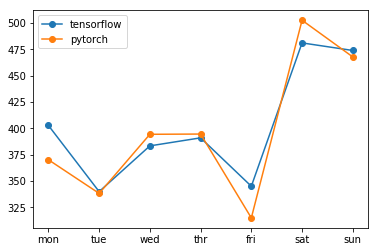

In [16]:
# plot scores
days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
plt.plot(days, rmse_tf[1], marker='o', label='tensorflow')
plt.plot(days, rmse_pt[1], marker='o', label='pytorch')
plt.legend()
plt.show()

**save rmse**

In [17]:
np.save(dir_data+'rmse_tf', rmse_tf[1])
np.save(dir_data+'rmse_pt', rmse_pt[1])